This notebook contains code that uses **Word2Vec** to generate word embeddings on proxy statements. This model is then trained, saved and can be loaded for future use. For instance, word embeddings can be used to cluster text. 

This notebook also contains code to do this. K-Means Clustering is used to cluster excerpts from the proxy statements. Additionally, clusters are visualized using wordclouds to detect most prominent keywords.

```tqdm``` is used to show a progress bar when running a cell.

In [3]:
from tqdm import tqdm
tqdm.pandas()

Import necessary libraries.

In [4]:
import string
import pickle
import joblib
import numpy as np
import pandas as pd
import nltk
import gensim
import re
import os
import math
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


#from nltk.stem.snowball import SnowballStemmer
#from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.preprocessing import normalize



###Word Embeddings: Word2Vec
from gensim.models import Word2Vec


###K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics


###WordCloud
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

###Word Frequency
from collections import Counter

This cell loads the parsed and cleaned csv file into a DataFrame called ```documents``` which contains the proxy statements. Each row is an excerpt/paragraph from a proxy statement. Columns include ```file_name```, ```text```, and ```clean_text```. The ```clean_text``` column includes stemmed words from ```text```.

In [5]:
documents = pd.read_csv("def14a_para_clean.csv")
print(documents.shape)
documents.head()

(406160, 4)


,Unnamed: 0,file_name,text,clean_text
0,37,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,"The Board of Directors of FlexShopper, Inc., ...",board director flexshopp delawar corpor compan...
1,39,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,We have established the close of business on ...,establish close busi septemb record date deter...
2,40,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,The Company's Board of Directors recommends t...,compani board director recommend stockhold con...
3,50,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,This Consent Solicitation Statement is being ...,consent solicit statement furnish connect soli...
4,52,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,The Company has decided to seek the written c...,compani decid seek written consent stockhold c...


The ```preprocess``` function preprocesses the ```text``` column: set to lowercase, removes digits, and whitespace. A new column named ```trial``` is added. The ```token_words``` function tokenizes each word in ```trial``` and removes punctuation. A new column named ```paragraph``` is added.

In [6]:
def preprocess(paragraph):
    text = re.sub(r'\[[0-9]*\]',' ',paragraph)
    text = re.sub(r'\s+',' ',text)
    text = text.lower()
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

def token_words(sentence_list): #sentence_list is a row in the datframe
    punctuation=nltk.word_tokenize(string.punctuation)
    paragraph = nltk.word_tokenize(sentence_list)
    
    return [token for token in paragraph if token not in punctuation]

documents['trial'] = documents.progress_apply(lambda x: preprocess(x['text']), axis = 1)
documents['paragraph'] = documents.progress_apply(lambda x: token_words(x['trial']), axis = 1)


100%|██████████| 406160/406160 [13:38<00:00, 496.46it/s]  


### Word2Vec needs a list of lists as input.
- Convert the ```paragraph``` column into a list.

In [7]:
paragraphs = documents.paragraph.tolist()

### Word2Vec
- Instantiate the model. **Skipgram** is used.

In [3]:
model = Word2Vec(sentences, size=150, window=10, min_count=2, workers=10, sg = 1)

- Train the model

In [14]:
model.train(sentences,total_examples=len(sentences),epochs=10)

2020-08-12 00:31:06,434 : WARNING : Effective 'alpha' higher than previous training cycles
2020-08-12 00:31:06,435 : INFO : training model with 10 workers on 64647 vocabulary and 150 features, using sg=1 hs=0 sample=0.001 negative=5 window=10
2020-08-12 00:31:07,449 : INFO : EPOCH 1 - PROGRESS: at 1.13% examples, 413308 words/s, in_qsize 18, out_qsize 1
2020-08-12 00:31:08,455 : INFO : EPOCH 1 - PROGRESS: at 2.30% examples, 431601 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:31:09,472 : INFO : EPOCH 1 - PROGRESS: at 3.61% examples, 443893 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:31:10,479 : INFO : EPOCH 1 - PROGRESS: at 4.71% examples, 443711 words/s, in_qsize 20, out_qsize 0
2020-08-12 00:31:11,501 : INFO : EPOCH 1 - PROGRESS: at 5.89% examples, 439864 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:31:12,507 : INFO : EPOCH 1 - PROGRESS: at 6.85% examples, 436214 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:31:13,540 : INFO : EPOCH 1 - PROGRESS: at 7.87% examples, 431124 

2020-08-12 00:32:18,734 : INFO : EPOCH 1 - PROGRESS: at 72.92% examples, 385619 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:32:19,760 : INFO : EPOCH 1 - PROGRESS: at 73.91% examples, 385587 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:32:20,796 : INFO : EPOCH 1 - PROGRESS: at 75.03% examples, 385839 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:32:21,814 : INFO : EPOCH 1 - PROGRESS: at 76.13% examples, 385982 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:32:22,828 : INFO : EPOCH 1 - PROGRESS: at 77.32% examples, 386271 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:32:23,845 : INFO : EPOCH 1 - PROGRESS: at 78.37% examples, 386448 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:32:24,846 : INFO : EPOCH 1 - PROGRESS: at 79.39% examples, 386577 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:32:25,850 : INFO : EPOCH 1 - PROGRESS: at 80.47% examples, 386837 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:32:26,868 : INFO : EPOCH 1 - PROGRESS: at 81.62% examples, 386999 words/s,

2020-08-12 00:33:23,250 : INFO : EPOCH 2 - PROGRESS: at 40.38% examples, 400534 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:33:24,257 : INFO : EPOCH 2 - PROGRESS: at 41.51% examples, 400820 words/s, in_qsize 18, out_qsize 1
2020-08-12 00:33:25,260 : INFO : EPOCH 2 - PROGRESS: at 42.58% examples, 401171 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:33:26,271 : INFO : EPOCH 2 - PROGRESS: at 43.53% examples, 400420 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:33:27,286 : INFO : EPOCH 2 - PROGRESS: at 44.46% examples, 399059 words/s, in_qsize 20, out_qsize 0
2020-08-12 00:33:28,402 : INFO : EPOCH 2 - PROGRESS: at 45.52% examples, 398133 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:33:29,419 : INFO : EPOCH 2 - PROGRESS: at 46.58% examples, 398084 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:33:30,458 : INFO : EPOCH 2 - PROGRESS: at 47.62% examples, 397104 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:33:31,502 : INFO : EPOCH 2 - PROGRESS: at 48.66% examples, 396746 words/s,

2020-08-12 00:34:28,222 : INFO : EPOCH 3 - PROGRESS: at 8.09% examples, 390504 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:34:29,239 : INFO : EPOCH 3 - PROGRESS: at 8.95% examples, 385858 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:34:30,244 : INFO : EPOCH 3 - PROGRESS: at 9.82% examples, 381372 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:34:31,247 : INFO : EPOCH 3 - PROGRESS: at 10.95% examples, 384227 words/s, in_qsize 20, out_qsize 0
2020-08-12 00:34:32,258 : INFO : EPOCH 3 - PROGRESS: at 11.99% examples, 384496 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:34:33,269 : INFO : EPOCH 3 - PROGRESS: at 13.00% examples, 386017 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:34:34,314 : INFO : EPOCH 3 - PROGRESS: at 14.11% examples, 387303 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:34:35,330 : INFO : EPOCH 3 - PROGRESS: at 15.07% examples, 387624 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:34:36,336 : INFO : EPOCH 3 - PROGRESS: at 15.98% examples, 387362 words/s, in

2020-08-12 00:35:41,753 : INFO : EPOCH 3 - PROGRESS: at 84.48% examples, 394599 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:35:42,774 : INFO : EPOCH 3 - PROGRESS: at 85.56% examples, 394733 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:35:43,790 : INFO : EPOCH 3 - PROGRESS: at 86.77% examples, 394992 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:35:44,839 : INFO : EPOCH 3 - PROGRESS: at 87.78% examples, 395054 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:35:45,844 : INFO : EPOCH 3 - PROGRESS: at 88.87% examples, 395317 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:35:46,861 : INFO : EPOCH 3 - PROGRESS: at 89.90% examples, 395425 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:35:47,867 : INFO : EPOCH 3 - PROGRESS: at 91.03% examples, 395629 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:35:48,868 : INFO : EPOCH 3 - PROGRESS: at 92.07% examples, 395576 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:35:49,870 : INFO : EPOCH 3 - PROGRESS: at 92.95% examples, 395581 words/s,

2020-08-12 00:36:46,561 : INFO : EPOCH 4 - PROGRESS: at 52.61% examples, 403456 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:36:47,572 : INFO : EPOCH 4 - PROGRESS: at 53.55% examples, 403273 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:36:48,575 : INFO : EPOCH 4 - PROGRESS: at 54.60% examples, 403050 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:36:49,577 : INFO : EPOCH 4 - PROGRESS: at 55.68% examples, 403255 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:36:50,583 : INFO : EPOCH 4 - PROGRESS: at 56.57% examples, 402766 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:36:51,616 : INFO : EPOCH 4 - PROGRESS: at 57.72% examples, 402857 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:36:52,634 : INFO : EPOCH 4 - PROGRESS: at 58.96% examples, 403187 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:36:53,664 : INFO : EPOCH 4 - PROGRESS: at 60.12% examples, 403323 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:36:54,666 : INFO : EPOCH 4 - PROGRESS: at 61.12% examples, 403475 words/s,

2020-08-12 00:37:51,105 : INFO : EPOCH 5 - PROGRESS: at 18.31% examples, 391597 words/s, in_qsize 19, out_qsize 1
2020-08-12 00:37:52,108 : INFO : EPOCH 5 - PROGRESS: at 19.36% examples, 391905 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:37:53,133 : INFO : EPOCH 5 - PROGRESS: at 20.47% examples, 392450 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:37:54,136 : INFO : EPOCH 5 - PROGRESS: at 21.48% examples, 392942 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:37:55,137 : INFO : EPOCH 5 - PROGRESS: at 22.53% examples, 392921 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:37:56,189 : INFO : EPOCH 5 - PROGRESS: at 23.59% examples, 392997 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:37:57,194 : INFO : EPOCH 5 - PROGRESS: at 24.74% examples, 394215 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:37:58,206 : INFO : EPOCH 5 - PROGRESS: at 25.79% examples, 395076 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:37:59,270 : INFO : EPOCH 5 - PROGRESS: at 26.94% examples, 395341 words/s,

2020-08-12 00:39:04,897 : INFO : EPOCH 5 - PROGRESS: at 96.30% examples, 398942 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:39:05,928 : INFO : EPOCH 5 - PROGRESS: at 97.35% examples, 398982 words/s, in_qsize 18, out_qsize 1
2020-08-12 00:39:06,934 : INFO : EPOCH 5 - PROGRESS: at 98.32% examples, 399091 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:39:07,942 : INFO : EPOCH 5 - PROGRESS: at 99.42% examples, 399295 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:39:08,330 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-08-12 00:39:08,348 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-08-12 00:39:08,350 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-12 00:39:08,355 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-12 00:39:08,360 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-12 00:39:08,369 : INFO : worker thread finished; awaiting finish of 4 more thread

2020-08-12 00:40:09,833 : INFO : EPOCH 6 - PROGRESS: at 63.48% examples, 396679 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:40:10,860 : INFO : EPOCH 6 - PROGRESS: at 64.65% examples, 396497 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:40:11,871 : INFO : EPOCH 6 - PROGRESS: at 65.71% examples, 396270 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:40:12,918 : INFO : EPOCH 6 - PROGRESS: at 66.68% examples, 396456 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:40:13,953 : INFO : EPOCH 6 - PROGRESS: at 67.80% examples, 396631 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:40:14,988 : INFO : EPOCH 6 - PROGRESS: at 68.93% examples, 396805 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:40:16,008 : INFO : EPOCH 6 - PROGRESS: at 70.10% examples, 397163 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:40:17,014 : INFO : EPOCH 6 - PROGRESS: at 71.17% examples, 397426 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:40:18,035 : INFO : EPOCH 6 - PROGRESS: at 72.39% examples, 397571 words/s,

2020-08-12 00:41:14,784 : INFO : EPOCH 7 - PROGRESS: at 31.62% examples, 400269 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:41:15,803 : INFO : EPOCH 7 - PROGRESS: at 32.66% examples, 400405 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:41:16,808 : INFO : EPOCH 7 - PROGRESS: at 33.68% examples, 400571 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:41:17,835 : INFO : EPOCH 7 - PROGRESS: at 34.77% examples, 400396 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:41:18,880 : INFO : EPOCH 7 - PROGRESS: at 35.97% examples, 400431 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:41:19,924 : INFO : EPOCH 7 - PROGRESS: at 37.08% examples, 400423 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:41:20,935 : INFO : EPOCH 7 - PROGRESS: at 38.18% examples, 400664 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:41:21,959 : INFO : EPOCH 7 - PROGRESS: at 39.16% examples, 399649 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:41:22,964 : INFO : EPOCH 7 - PROGRESS: at 40.30% examples, 399839 words/s,

2020-08-12 00:42:20,053 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-12 00:42:20,053 : INFO : EPOCH - 7 : training on 54111836 raw words (38199702 effective words) took 95.8s, 398664 effective words/s
2020-08-12 00:42:21,072 : INFO : EPOCH 8 - PROGRESS: at 1.05% examples, 373866 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:42:22,110 : INFO : EPOCH 8 - PROGRESS: at 2.17% examples, 396262 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:42:23,111 : INFO : EPOCH 8 - PROGRESS: at 3.28% examples, 403639 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:42:24,142 : INFO : EPOCH 8 - PROGRESS: at 4.35% examples, 404158 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:42:25,147 : INFO : EPOCH 8 - PROGRESS: at 5.50% examples, 406629 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:42:26,154 : INFO : EPOCH 8 - PROGRESS: at 6.43% examples, 404609 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:42:27,179 : INFO : EPOCH 8 - PROGRESS: at 7.44% examples, 402351 words/s, in_

2020-08-12 00:43:32,715 : INFO : EPOCH 8 - PROGRESS: at 75.18% examples, 395556 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:43:33,745 : INFO : EPOCH 8 - PROGRESS: at 76.34% examples, 395798 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:43:34,748 : INFO : EPOCH 8 - PROGRESS: at 77.50% examples, 395932 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:43:35,768 : INFO : EPOCH 8 - PROGRESS: at 78.51% examples, 395786 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:43:36,786 : INFO : EPOCH 8 - PROGRESS: at 79.59% examples, 395914 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:43:37,860 : INFO : EPOCH 8 - PROGRESS: at 80.76% examples, 395868 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:43:38,882 : INFO : EPOCH 8 - PROGRESS: at 81.86% examples, 395977 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:43:39,883 : INFO : EPOCH 8 - PROGRESS: at 82.90% examples, 396007 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:43:40,887 : INFO : EPOCH 8 - PROGRESS: at 83.88% examples, 395838 words/s,

2020-08-12 00:44:37,054 : INFO : EPOCH 9 - PROGRESS: at 42.56% examples, 402027 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:44:38,066 : INFO : EPOCH 9 - PROGRESS: at 43.63% examples, 402253 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:44:39,071 : INFO : EPOCH 9 - PROGRESS: at 44.69% examples, 402454 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:44:40,092 : INFO : EPOCH 9 - PROGRESS: at 45.71% examples, 401644 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:44:41,147 : INFO : EPOCH 9 - PROGRESS: at 46.84% examples, 401660 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:44:42,153 : INFO : EPOCH 9 - PROGRESS: at 47.99% examples, 402044 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:44:43,153 : INFO : EPOCH 9 - PROGRESS: at 49.09% examples, 402353 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:44:44,209 : INFO : EPOCH 9 - PROGRESS: at 50.27% examples, 402352 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:44:45,317 : INFO : EPOCH 9 - PROGRESS: at 51.32% examples, 402102 words/s,

2020-08-12 00:45:41,275 : INFO : EPOCH 10 - PROGRESS: at 9.10% examples, 389892 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:45:42,318 : INFO : EPOCH 10 - PROGRESS: at 10.18% examples, 391229 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:45:43,356 : INFO : EPOCH 10 - PROGRESS: at 11.32% examples, 392788 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:45:44,368 : INFO : EPOCH 10 - PROGRESS: at 12.38% examples, 391505 words/s, in_qsize 18, out_qsize 1
2020-08-12 00:45:45,372 : INFO : EPOCH 10 - PROGRESS: at 13.34% examples, 392663 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:45:46,388 : INFO : EPOCH 10 - PROGRESS: at 14.33% examples, 391182 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:45:47,398 : INFO : EPOCH 10 - PROGRESS: at 15.20% examples, 391858 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:45:48,398 : INFO : EPOCH 10 - PROGRESS: at 16.32% examples, 392820 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:45:49,399 : INFO : EPOCH 10 - PROGRESS: at 17.36% examples, 391551 

2020-08-12 00:46:54,773 : INFO : EPOCH 10 - PROGRESS: at 86.56% examples, 398848 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:46:55,860 : INFO : EPOCH 10 - PROGRESS: at 87.60% examples, 398682 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:46:56,893 : INFO : EPOCH 10 - PROGRESS: at 88.65% examples, 398780 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:46:57,952 : INFO : EPOCH 10 - PROGRESS: at 89.70% examples, 398648 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:46:58,954 : INFO : EPOCH 10 - PROGRESS: at 90.80% examples, 398817 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:46:59,976 : INFO : EPOCH 10 - PROGRESS: at 91.84% examples, 398501 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:47:00,997 : INFO : EPOCH 10 - PROGRESS: at 92.72% examples, 398436 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:47:01,999 : INFO : EPOCH 10 - PROGRESS: at 93.88% examples, 398597 words/s, in_qsize 19, out_qsize 0
2020-08-12 00:47:03,000 : INFO : EPOCH 10 - PROGRESS: at 94.88% examples, 398360

(382032776, 541118360)

### Word Embedding Vocabulary
- This code shows the vocabulary that was generated by the model.

In [31]:
words = model.wv.vocab
words

{'the': <gensim.models.keyedvectors.Vocab at 0x1a42564250>,
 'board': <gensim.models.keyedvectors.Vocab at 0x1a4254e250>,
 'of': <gensim.models.keyedvectors.Vocab at 0x1a4254ed10>,
 'directors': <gensim.models.keyedvectors.Vocab at 0x1a4254ed50>,
 'flexshopper': <gensim.models.keyedvectors.Vocab at 0x1a4254edd0>,
 ',': <gensim.models.keyedvectors.Vocab at 0x1a4254efd0>,
 'inc.': <gensim.models.keyedvectors.Vocab at 0x1a4254e850>,
 'a': <gensim.models.keyedvectors.Vocab at 0x1a4254e8d0>,
 'delaware': <gensim.models.keyedvectors.Vocab at 0x1a4254ec90>,
 'corporation': <gensim.models.keyedvectors.Vocab at 0x1a4254ee50>,
 '(': <gensim.models.keyedvectors.Vocab at 0x1a4254ee10>,
 '``': <gensim.models.keyedvectors.Vocab at 0x1a4254ef90>,
 'company': <gensim.models.keyedvectors.Vocab at 0x1a4254e910>,
 "''": <gensim.models.keyedvectors.Vocab at 0x1a4254e9d0>,
 'we': <gensim.models.keyedvectors.Vocab at 0x1a4254ec10>,
 'us': <gensim.models.keyedvectors.Vocab at 0x1a4254ed90>,
 'or': <gensim.mo

This code shows what you can do with the vocabulary. For instance, you can find a word vector for a specific word. You can also predict the most similar words of a specific word. Moreover, you can check the similarity scores of words.

In [35]:
# Finding Word Vectors
vector = model.wv['labor']


# Most similar words i.e. predicted the next words
similar = model.wv.most_similar('coercion')
print(similar)

# #Similarity scores
# model.wv.similarity('trafficking', 'labor')

[('compulsion', 0.9174182415008545), ('indentured', 0.8123453855514526), ('trafficking', 0.7260526418685913), ('anti-human', 0.7255998849868774), ('infliction', 0.7242321968078613), ('earthquakes', 0.7108502388000488), ('whistleblowers', 0.7089771032333374), ('disobedience', 0.6867412328720093), ('defamation', 0.6819101572036743), ('toxins', 0.6767427921295166)]


Under the hood, the above three code snippets computes the cosine similarity between the two specified words using word vectors of each. If you do a similarity between two identical words, the score will be 1.0 as the range of the cosine similarity score will always be between [0.0-1.0].

### Save/Load the Trained Word Embeddings
- The code below can be used to save the model.
- There is also code that can be used to load an already saved Word2Vec model.

In [8]:
#SAVE
#Uncomment the code below to save the model.
#model.save('word2vec_proxy_docs.model')

#LOAD
model = gensim.models.Word2Vec.load("word2vec_proxy_docs.model")

2020-08-31 13:17:49,941 : INFO : loading Word2Vec object from word2vec_proxy_docs.model
2020-08-31 13:17:51,439 : INFO : loading wv recursively from word2vec_proxy_docs.model.wv.* with mmap=None
2020-08-31 13:17:51,439 : INFO : setting ignored attribute vectors_norm to None
2020-08-31 13:17:51,440 : INFO : loading vocabulary recursively from word2vec_proxy_docs.model.vocabulary.* with mmap=None
2020-08-31 13:17:51,440 : INFO : loading trainables recursively from word2vec_proxy_docs.model.trainables.* with mmap=None
2020-08-31 13:17:51,441 : INFO : setting ignored attribute cum_table to None
2020-08-31 13:17:51,441 : INFO : loaded word2vec_proxy_docs.model


### K Means Clustering

- Word embeddings can be used to cluster text. In this case, paragraphs are clustered.
- Find the Optimal Number of Clusters.
- Fit data into K-Means. Save into a pickle doc.

#### Paragraph Clustering

The function ```paragraph_vectorizer```: For each paragraph from the set of paragraphs, word embedding of each word is summed and in the end divided by number of words in the paragraph. So we are getting average of all word embeddings for each paragraph and use them as we would use embeddings at word level – feeding to machine learning clustering algorithm such as k-means.

In [25]:
def paragraph_vectorizer(paragraph, model):
    paragraph_vec =[]
    numw = 0 #number of word in the paragraph
    for w in paragraph:
        try:
            if numw == 0:
                paragraph_vec = model.wv[w]
            else:
                paragraph_vec = np.add(paragraph_vec, model.wv[w])
            numw+=1
        except:
            pass
        
    if len(paragraph_vec) == 150:
     
        return np.asarray(paragraph_vec) / numw
    else:
        return None

This cell creates the vectorized paragraphs. X is used as the input to K-Means. It also takes note of the paragraphs that do not have vectors based on their index.

In [26]:
X=[]
for idx, paragraph in tqdm(enumerate(paragraphs)):
    result=paragraph_vectorizer(paragraph, model)
    if result is None:
        print('No Vector for Paragraph: {a}'.format(a=idx))
    else:  
        X.append(paragraph_vectorizer(paragraph, model)) 

# empty array rows: 324639, 324640, 324642, 324643, 324645, 324646

324897it [02:34, 2028.24it/s]

No Vector for Paragraph: 324639
No Vector for Paragraph: 324640
No Vector for Paragraph: 324642
No Vector for Paragraph: 324643
No Vector for Paragraph: 324645
No Vector for Paragraph: 324646


406160it [03:13, 2101.82it/s]


This cell is used to find the optimal number of clusters. First, within_cluster_variance is found. K-Means minimizes this and maximizes between-cluster variance. The objective is to find the most compact partitioning of the data set into 𝑘 partitions.

In [67]:
#OPTIMAL NUMBER OF CLUSTERS: get within cluster variance
within_cluster_variance = []
for k in tqdm(range(2,21)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    within_cluster_variance.append(kmeans.inertia_)

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

optimal_number_of_clusters(within_cluster_variance)

6

Using optimal number of clusters, fit data into K-Means.

In [27]:
word_emb_kmeans = KMeans(n_clusters=6)
word_emb_kmeans.fit(X)

#Convert labels into a list
labels = word_emb_kmeans.labels_.tolist()

#Centroids
centroids = word_emb_kmeans.cluster_centers_


### Save the Clusters into pickle file

In [10]:
#Path to folder
data_dir = 'cluster_pkl' #directory name

#name of new file to be pickled, change this every time you run clustering model again
cluster_file = '/word_emb_clust_2_par.pkl' 
path = data_dir + cluster_file

In [50]:
#Save the Pickle File
joblib.dump(word_emb_kmeans,  open( path, "wb" )) #pickle doc

In [11]:
#LOAD CLUSTER FILE
word_emb_kmeans_load = joblib.load(path)
word_emb_labels = word_emb_kmeans_load.labels_.tolist() #labels

word_emb_clust_centers = word_emb_kmeans_load.cluster_centers_ # centers

### Insert "None" into Labels that do not have a Vector.
This means then that these paragraphs do not have a cluster.
If there exists "No vectors For Paragraph No. __" (see above code), then insert ```None``` into ```labels```.

In [12]:
word_emb_labels.insert(324639, None)
word_emb_labels.insert(324640, None)
word_emb_labels.insert(324642, None)
word_emb_labels.insert(324643, None)
word_emb_labels.insert(324645, None)
word_emb_labels.insert(324646, None)

### Add the K-Means Cluster Labels to the Original DataFrame
This cell adds the column ```cluster``` to the original dataframe. Now, the paragraphs are assigned to a cluster.

In [13]:
documents['cluster'] = word_emb_labels #add labels to the original dataframe
documents.head(10)

,Unnamed: 0,file_name,text,clean_text,trial,paragraph,cluster
0,37,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,"The Board of Directors of FlexShopper, Inc., ...",board director flexshopp delawar corpor compan...,"the board of directors of flexshopper, inc., ...","[the, board, of, directors, of, flexshopper, i...",3.0
1,39,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,We have established the close of business on ...,establish close busi septemb record date deter...,we have established the close of business on ...,"[we, have, established, the, close, of, busine...",4.0
2,40,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,The Company's Board of Directors recommends t...,compani board director recommend stockhold con...,the company's board of directors recommends t...,"[the, company, 's, board, of, directors, recom...",4.0
3,50,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,This Consent Solicitation Statement is being ...,consent solicit statement furnish connect soli...,this consent solicitation statement is being ...,"[this, consent, solicitation, statement, is, b...",3.0
4,52,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,The Company has decided to seek the written c...,compani decid seek written consent stockhold c...,the company has decided to seek the written c...,"[the, company, has, decided, to, seek, the, wr...",1.0
5,53,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,"Voting materials, which include this Consent ...",vote materi includ consent solicit statement a...,"voting materials, which include this consent ...","[voting, materials, which, include, this, cons...",4.0
6,57,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,Stockholders who wish to consent must deliver...,stockhold wish consent must deliv properli com...,stockholders who wish to consent must deliver...,"[stockholders, who, wish, to, consent, must, d...",3.0
7,58,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,The entire cost of furnishing this Consent So...,entir cost furnish consent solicit statement b...,the entire cost of furnishing this consent so...,"[the, entire, cost, of, furnishing, this, cons...",4.0
8,60,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,Stockholder approval of the Certificate of Am...,stockhold approv certif amend effect upon rece...,stockholder approval of the certificate of am...,"[stockholder, approval, of, the, certificate, ...",3.0
9,62,_UNK_DEF 14A_20181110_0001213900-18-013745.txt,If your shares are held in a brokerage accoun...,share held brokerag account broker name street...,if your shares are held in a brokerage accoun...,"[if, your, shares, are, held, in, a, brokerage...",4.0


The function ```find_word_by_cluster``` shows you the actual text in each cluster and where you would like to search for a particular word. You can use the **CSAG** terms here to check which cluster the words are in.

In [22]:
#CHECK THE WORDS FOUND IN THE PARAGRAPH FOR EACH CLUSTER:
def find_word_by_cluster(word, cluster_num): 
    """
    Inputs: word is a string
    cluster_num is a number from 0 to 5
    """
    par_list = []
    for i, par in enumerate(documents['text'][documents['cluster']==cluster_num]): #clusters 0-5
        if word in par:
            par_list.append(par)
            print(str(i+1) + '.', par)
            print()
    if len(par_list) == 0:
        print("This cluster does not contain the specific word.")
            
find_word_by_cluster('trafficking', 1)

24478. • Our Supply Chain Protocol, to help us select suppliers that conform to our Supplier Code of Conduct, i.e., share our  commitment to comply with all applicable laws, prohibit corruption, respect basic human rights of employees, prohibit child labor, mitigate the risk of slavery and human trafficking in our supply chain, take responsibility for the health and safety  of employees, and promote these standards down the supply chain to lower-tier contractors or suppliers; and  

28707.  McDermott is committed to respecting human rights wherever we operate, in accordance with applicable laws and consistent with the U.N. Guiding Principles on Business and Human Rights. Our commitment to human rights includes the provision of quality work conditions that comply with all applicable labor laws and the International Labour Organization's core conventions/Declaration on Fundamental Principles and Rights at Work, including labor principles related to freedom of association and nondiscrimin

### Word Cloud: Find top keywords in each paragraph cluster
- If you want to find the most important keywords per cluster, make a WordCloud.
The function ```wordcloud_cluster``` generates a wordcloud for a cluster.

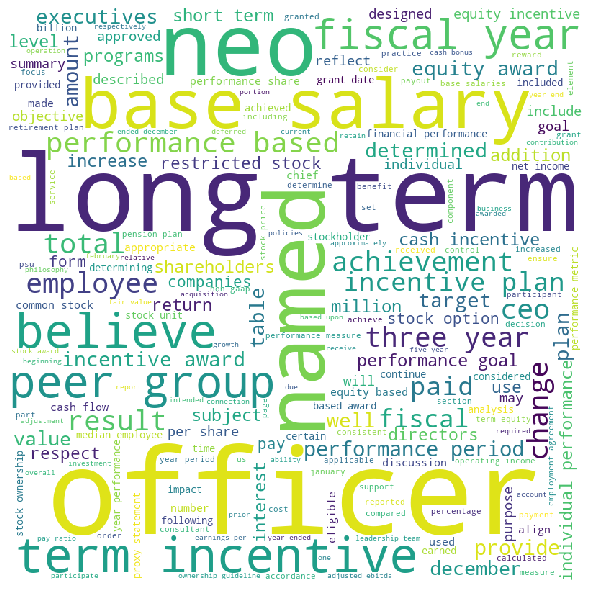

In [67]:
def wordcloud_cluster(cluster_num):
    cluster_df = documents[documents['cluster']==cluster_num]
    cluster_words = '' 
    stopwords = set(STOPWORDS) 
    stopwords.update(["executive", "board", "committee", "governance", "company", "accounting", "compensation",
                 "corporate", "annual", "director", "meeting", "audit", "public", "shareholder", "independent", "member",
                 "firm", "nominating", "program", "review", "auditor", "officer", "executives"])


    # iterate through the csv file 
    for val in cluster_df.text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        cluster_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(cluster_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()
    
wordcloud_cluster(2)

#### CSAG dictionary of terms and added words from word embeddings
- These are the words from Civil Society Advisory Board. Word embeddings can help seed the list of words to create a dictionary.
- These words are **keywords** that will be used to count how many times they occur in the cluster. We want to know this to get a signal that the cluster contains 'human rights' related risks which would be the **positive** case.

In [56]:
csag_terms = ['human', 'capital', 'labor', 'bondage', 'workers', 
'health', 'safety', 'diversity', 'inclusion', 'labor', 'relations', 'culture', 
'resources', 'contractors', 'fair', 'wage',
'minimum', 'overtime', 'exploitative', 'injuries', 'protective', 
'equipment', 'workforce', 'working', 'conditions',
'discrimination', 'contractor', 'strike', 'recruitment', 'hiring', 'forced', 
'collective', 'bargaining', 'union', 'organizing', 'pay', 'ratio', 'equity', 
'grievance', 'retaliation', 'whistleblowers', 'modern', 'slavery', 
'incident', 'harassment', 'compulsion', 'unethical', 'anti-retaliation', 
'intolerance', 'anti-corruption','anti-bribery', 'retaliation', 'indentured', 'anti-human', 'trafficking']

We can try it first on Cluster 2. Find the top keywords in Cluster 2. The ```top_csag_words_by_cluster``` function shows the frequency of the CSAG words that were found in the Cluster. As an example, Cluster 2 is used.

In [95]:
def top_csag_words_by_cluster(cluster_num, num_keywords):
    #Join paragraphs from cluster 2 into one string
    cluster_text = documents[documents['cluster']==cluster_num]
    par = ' '.join(cluster_text['text'])
    
    c = Counter(''.join(char for char in s.lower() if char.isalpha()) 
                for s in par.split())


    term_freq = [c[term] for term in csag_terms]

    #DataFrame of Word and Term Frequency
    word_freq_df = pd.DataFrame({'csag_terms': csag_terms, 'word_freq':term_freq})

    #Top 10 CSAG terms in Cluster 2
    return word_freq_df.sort_values(by=['word_freq'], ascending=False).head(num_keywords)

top_csag_words_by_cluster(2, 10)

,csag_terms,word_freq
37,equity,24305
35,pay,21455
1,capital,8360
36,ratio,5538
7,diversity,3721
5,health,3546
14,fair,3502
16,minimum,2695
24,conditions,2627
6,safety,2506


This code shows the word frequency in the cluster. As an example. Cluster 2 is used. In order to get more meaningful keywords, stopwords should be used. Creating custom stopwords involves knowing boilerplate language on proxy statements. This would be the next step. 

In [87]:
for term in c.most_common()[0:10]:
    print(term[0])

the

of
and
to
in
our
for
compensation
a
